In [1]:
import sys
sys.path.append("../helper_functions")
import duneapi_utils as d
import l2beat_utils as ltwo
sys.path.pop()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# # Get token classification
# # https://dune.com/queries/3852319
token_df = d.get_dune_data(query_id = 3852319,
    name = "tokens_by_type_base_opm",
    performance = 'large'#,
    # num_hours_to_rerun=0
)

token_df.sample(5)

2024-06-21 19:40:28.553 | INFO     | duneapi_utils:get_dune_data:58 - Results available at https://dune.com/queries/3852319
2024-06-21 19:40:29.313 | INFO     | duneapi_utils:get_dune_data:105 - ✨ Results saved as csv_outputs/tokens_by_type_base_opm.csv, with 457 rows and 8 columns.


,blockchain,chain_id,factory_address,l1_token,symbol,token_address,token_classification,last_updated
265,base,8453,None,0x6b0b3a982b4634ac68dd83a4dbf02311ce324181,ALI,0x97c806e7665d3afd84a8fe1837921403d59f3dcc,Not Proxy or Factory,2024-06-21 23:14:19.221240
266,base,8453,0xf23d369d7471bd9f6487e198723eea023389f1d4,0xed35af169af46a02ee13b9d79eb57d6d68c1749e,OMI,0x3792dbdd07e87413247df995e692806aa13d3299,Immutable Factory Created,2024-06-21 23:14:19.221240
151,base,8453,0x4200000000000000000000000000000000000012,0xb49fa25978abf9a248b8212ab4b87277682301c0,SOFI,0x703d57164ca270b0b330a87fd159cfef1490c0a5,Immutable Factory Created,2024-06-21 23:14:19.221240
104,base,8453,0x4200000000000000000000000000000000000012,0xa0246c9032bc3a600820415ae600c6388619a14d,FARM,0xd08a2917653d4e460893203471f0000826fb4034,Immutable Factory Created,2024-06-21 23:14:19.221240
407,base,8453,0xf23d369d7471bd9f6487e198723eea023389f1d4,0x37329f8f4571aeae1ea7bd1d4ff05dfc438cd422,None,0x1d34e08120dbd1ea9bdbcd90c2dc919b50ddff4c,Immutable Factory Created,2024-06-21 23:14:19.221240


In [3]:
# Get Lastest L2B aoc
l2b_df = ltwo.get_daily_aoc_by_token()
l2b_df_spc = l2b_df[l2b_df['project'].isin(['optimism','base'])]
l2b_df_spc = l2b_df_spc.rename(columns={'project':'blockchain'})

l2b_df_spc = l2b_df_spc[['dt','blockchain','token_type','asset_id','address','usd_value']]
l2b_df_spc['address'] = l2b_df_spc['address'].str.lower()

l2b_df_spc.sample(5)

,dt,blockchain,token_type,asset_id,address,usd_value
237,2024-06-21,base,canonical,trac-trace-token,0xaa7a9ca87d3694b5755f213b5d04094b8d0f0a6f,1.939500e+02
751,2024-06-21,optimism,canonical,zrx-0x-protocol-token,0xe41d2489571d322189246dafa5ebde1f4699f498,1.508083e+05
259,2024-06-21,base,native,base:usdc-usd-coin,0x833589fcd6edb6e08f4c7c32d4f71b54bda02913,3.055468e+09
760,2024-06-21,optimism,canonical,ens-ethereum-name-service,0xc18360217d8f7ab5e7c516566761ea12ce7f9d72,1.926004e+05
823,2024-06-21,optimism,native,op-optimism,0x4200000000000000000000000000000000000042,2.056941e+09


In [4]:
cols = ['blockchain','token_address','l1_token','token_classification','symbol']
token_if_l1_df = token_df[cols].rename(columns={'l1_token':'address'})
token_if_l2_df = token_df[cols].rename(columns={'token_address':'address'})

In [5]:
df_cols = ['blockchain','address','token_classification']
token_if_l1_df = token_if_l1_df[~token_if_l1_df['address'].isna()][df_cols].drop_duplicates()
token_if_l2_df = token_if_l2_df[~token_if_l2_df['address'].isna()][df_cols].drop_duplicates()

token_if_l2_df.sample(5)

,blockchain,address,token_classification
60,base,0x90eb5f8310c6d2289ef2475d9b8ae44589663d58,Immutable Factory Created
408,base,0x1f9535bddfa3fd15f39c9db1b04d42f3a0195425,Immutable Factory Created
273,base,0x93dc5cb35627a759848c7a7f0079ea7b49e435a5,Immutable Factory Created
193,optimism,0xa7cb49a22809a78d5a5258af532c84dd2744011f,Immutable Factory Created
137,optimism,0x2218a117083f5b482b0bb821d27056ba9c04b1d3,Immutable Factory Created


In [6]:
#L2 Mapping preferred
unified_df = l2b_df_spc.merge(token_if_l2_df
                              , on=['blockchain','address'], how='left')
#L1 Mapping fallback
unified_df = unified_df.merge(token_if_l1_df
                              , on=['blockchain','address'], how='left')


In [7]:
unified_df['token_classification'] = unified_df['token_classification_x'].fillna(unified_df['token_classification_y']).fillna('Unknown')

unified_df = unified_df.drop(columns=['token_classification_x', 'token_classification_y'])

In [8]:
unified_df['token_classification'] = unified_df.apply(
    lambda row: 'Native' if row['asset_id'] == 'eth-ether' else row['token_classification'], axis=1
)
# Override due to bad Base events
unified_df['token_classification'] = unified_df.apply(
    lambda row: 'Proxy' if row['asset_id'] == 'base:usdc-usd-coin' else row['token_classification'], axis=1
)
# Override OP predeploy
unified_df['token_classification'] = unified_df.apply(
    lambda row: 'Predeploy' if row['asset_id'] == 'op-optimism' else row['token_classification'], axis=1
)

In [9]:
#Drop dupes where 1 L1 maps to multiple L2 tokens
unified_df = unified_df.drop_duplicates(keep='first')
unified_df.to_csv('csv_outputs/aoc_by_chain_token_classification.csv')

In [10]:
unified_df[unified_df['address']=='0x833589fcd6edb6e08f4c7c32d4f71b54bda02913']#.sample(5)

,dt,blockchain,token_type,asset_id,address,usd_value,token_classification
42,2024-06-21,base,native,base:usdc-usd-coin,0x833589fcd6edb6e08f4c7c32d4f71b54bda02913,3.055468e+09,Proxy


In [11]:
grouped_df = unified_df.groupby(['blockchain', 'token_type', 'token_classification'])['usd_value'].sum().reset_index()

# Calculate the total usd_value for each blockchain
total_by_blockchain = grouped_df.groupby('blockchain')['usd_value'].sum().reset_index()
total_by_blockchain = total_by_blockchain.rename(columns={'usd_value': 'total_usd_value_by_blockchain'})
# Merge the total_by_blockchain back into the grouped_df
grouped_df = grouped_df.merge(total_by_blockchain, on='blockchain')
# Calculate the overall total usd_value
overall_total = grouped_df['usd_value'].sum()
# Add new columns for the percentages
grouped_df['percent_of_blockchain'] = (grouped_df['usd_value'] / grouped_df['total_usd_value_by_blockchain']) * 100
grouped_df['percent_of_overall'] = (grouped_df['usd_value'] / overall_total) * 100
# Drop the total_usd_value_by_blockchain column as it's no longer needed
grouped_df = grouped_df.drop(columns=['total_usd_value_by_blockchain'])
# Display the updated DataFrame
# print(grouped_df)
# # Display the grouped table
grouped_df.sort_values(by='usd_value',ascending=False)

,blockchain,token_type,token_classification,usd_value,percent_of_blockchain,percent_of_overall
6,base,native,Proxy,3.101454e+09,42.485377,22.209051
13,optimism,native,Unknown,2.421004e+09,36.325392,17.336447
7,base,native,Unknown,2.121393e+09,29.059970,15.190977
1,base,canonical,Native,1.773026e+09,24.287856,12.696374
9,optimism,canonical,Native,1.739081e+09,26.093648,12.453303
10,optimism,canonical,Not Proxy or Factory,1.303430e+09,19.557019,9.333670
8,optimism,canonical,Immutable Factory Created,9.995750e+08,14.997893,7.157808
11,optimism,canonical,Unknown,1.927666e+08,2.892322,1.380373
3,base,canonical,Proxy,1.327087e+08,1.817915,0.950307
0,base,canonical,Immutable Factory Created,9.536358e+07,1.306341,0.682884


In [12]:
grouped_df = grouped_df[~grouped_df['blockchain'].isna()]

/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_2310/346545553.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'blockchain': blockchain, 'token_type': token_type,
/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_2310/346545553.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'blockchain': blockchain, 'token_type': token_type,
/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_2310/346545553.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'blockchain': blockchain, 'token_type': token_type,
/var/folders/by/kltjc8yd0yz_7_wrtrzhrm9m0000gn/T/ipykernel_2310/346545553.py:35: FutureWarning: The frame.append method is deprecated an

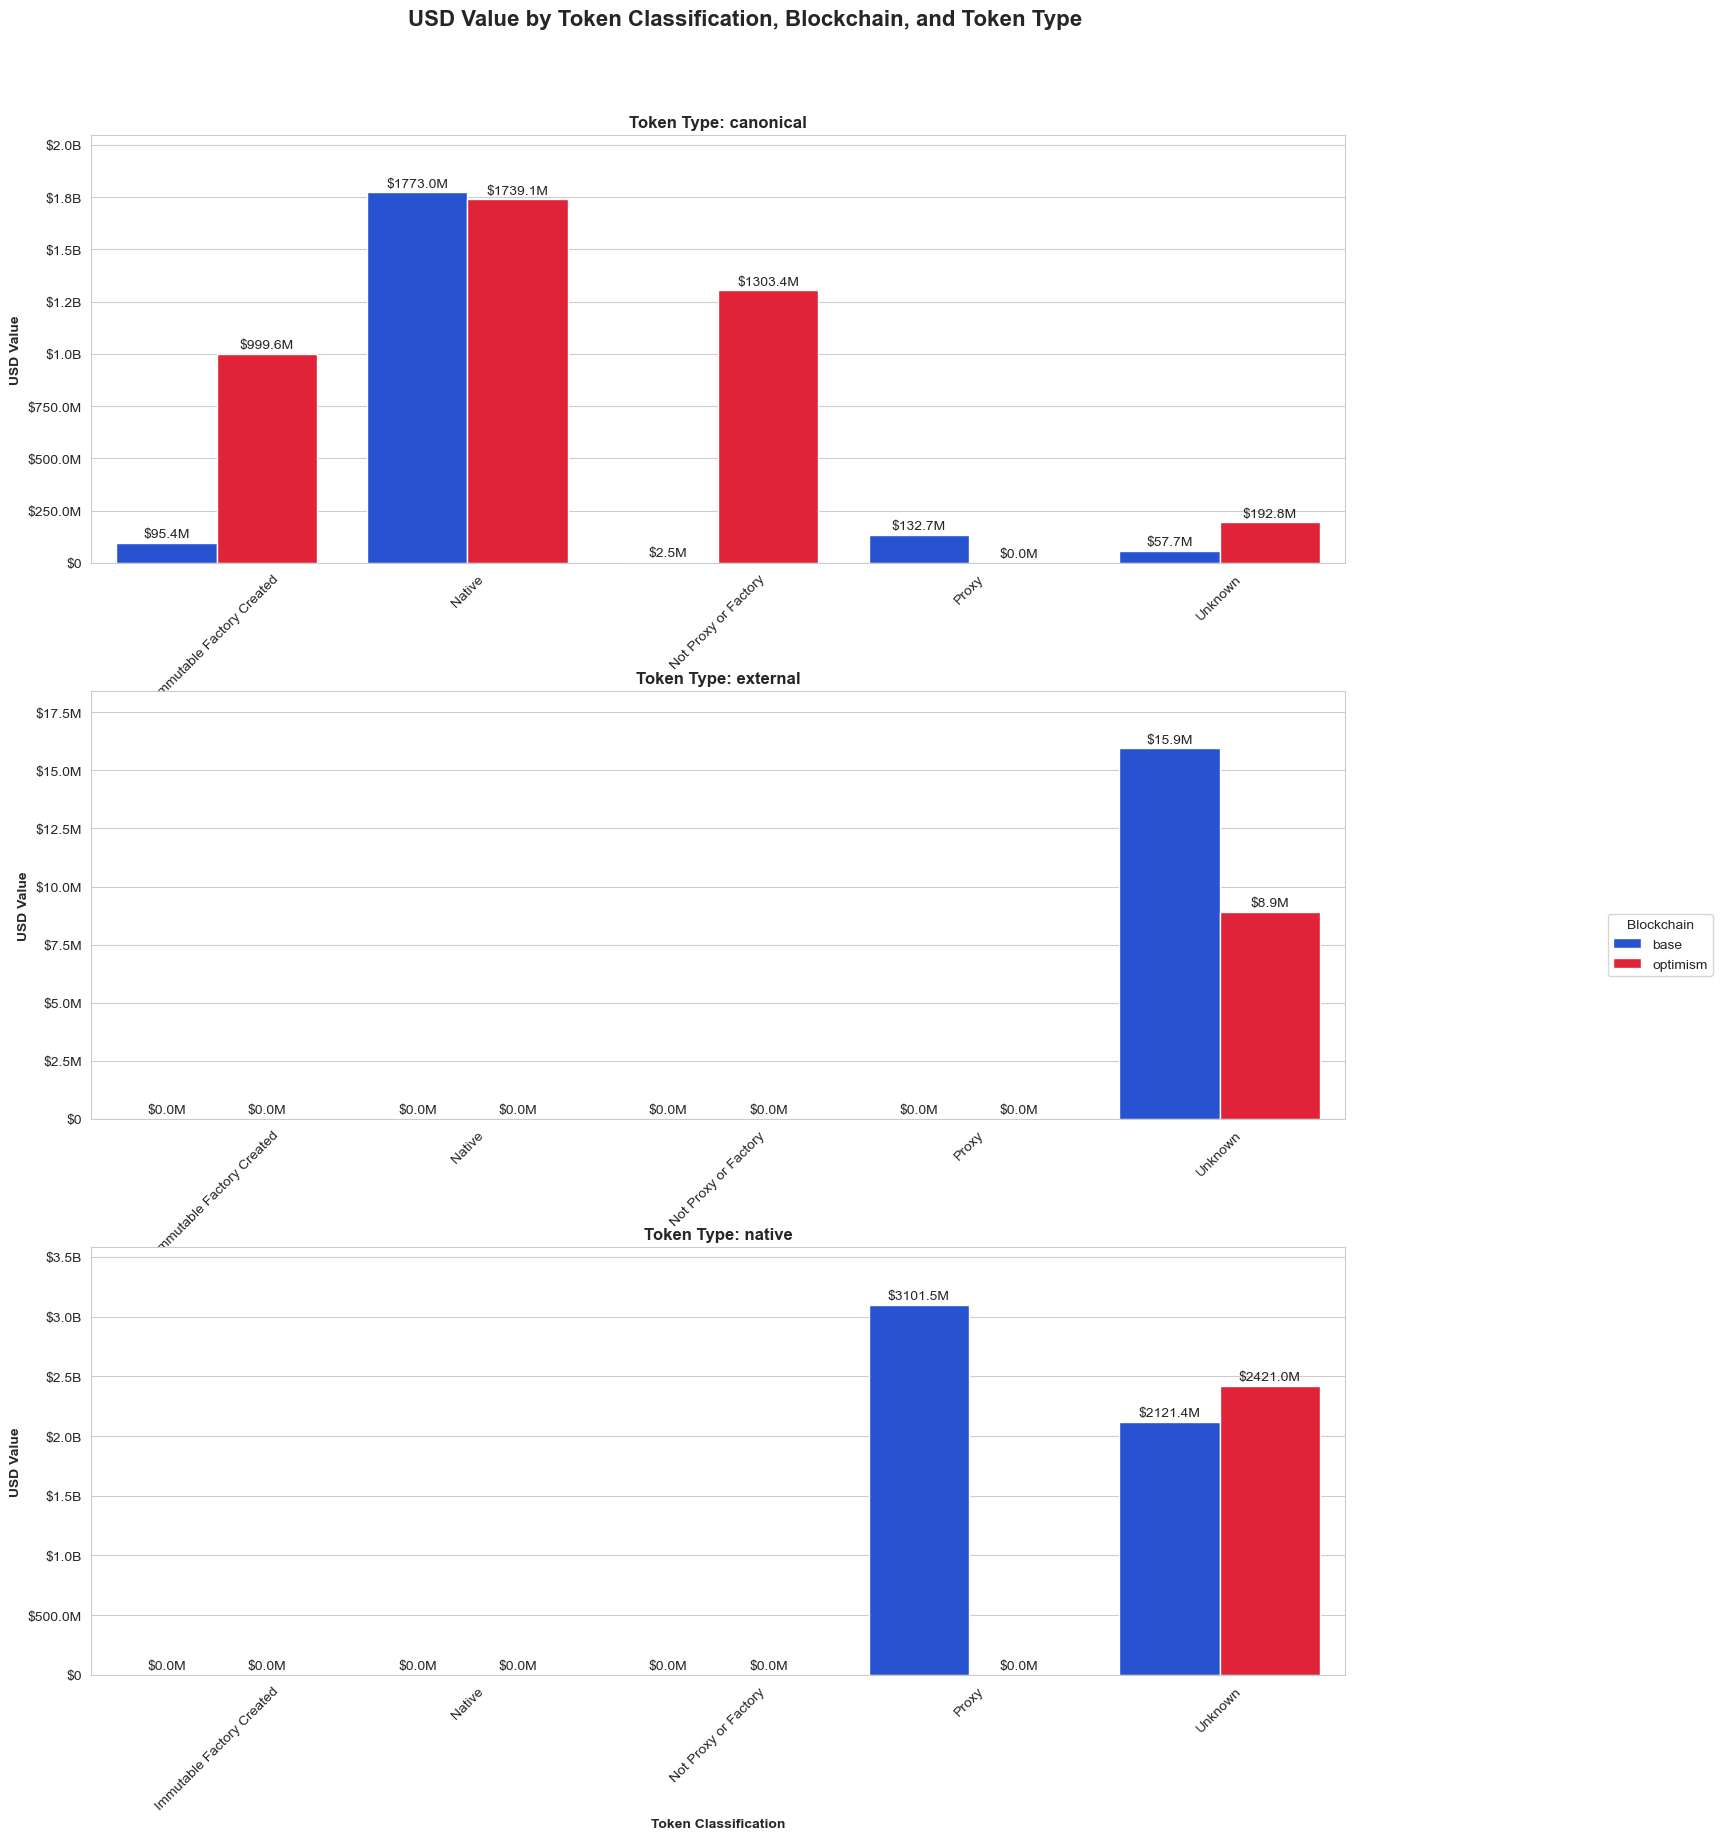

In [13]:
# Get all unique token_classifications
all_classifications = sorted(grouped_df['token_classification'].unique())

# Set up the plot
sns.set_style("whitegrid")
token_types = grouped_df['token_type'].unique()
fig, axes = plt.subplots(len(token_types), 1, figsize=(15, 6*len(token_types)), squeeze=False)
fig.suptitle("USD Value by Token Classification, Blockchain, and Token Type", fontsize=16, fontweight='bold', y=1.02)

# Color palette
color_palette = {"optimism": "#ff0420", "base": "#0b45ed"}

# Function to format y-axis labels
def format_func(value, tick_number):
    if value >= 1e9:
        return f'${value/1e9:.1f}B'
    elif value >= 1e6:
        return f'${value/1e6:.1f}M'
    else:
        return f'${value:.0f}'

# Function to format bar labels
def format_bar_label(value):
    return f'${value/1e6:.1f}M'

# Create a plot for each token_type
for i, token_type in enumerate(token_types):
    ax = axes[i, 0]
    data = grouped_df[grouped_df['token_type'] == token_type]
    
    # Ensure all classifications are present
    for blockchain in data['blockchain'].unique():
        for classification in all_classifications:
            if not ((data['blockchain'] == blockchain) & (data['token_classification'] == classification)).any():
                data = data.append({'blockchain': blockchain, 'token_type': token_type, 
                                    'token_classification': classification, 'usd_value': 0}, ignore_index=True)
    
    # Create the bar plot with a consistent order for token_classification
    sns.barplot(x='token_classification', y='usd_value', hue='blockchain', data=data, 
                palette=color_palette, ax=ax, order=all_classifications)
    
    # Customize the plot
    ax.set_title(f"Token Type: {token_type}", fontweight='bold')
    ax.set_xlabel("Token Classification", fontweight='bold')
    ax.set_ylabel("USD Value", fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    
    # Add value labels on top of the bars
    for container in ax.containers:
        ax.bar_label(container, fmt=format_bar_label, label_type='edge', padding=2)
    
    # Remove individual legends
    ax.get_legend().remove()
    
    # Adjust y-axis limit to accommodate bar labels
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1] * 1.1)  # Increase the upper limit by 10%

# Add a single legend for all subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, title="Blockchain", loc="center right", bbox_to_anchor=(1.15, 0.5))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95, right=0.9, hspace=0.3)
plt.show()